In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

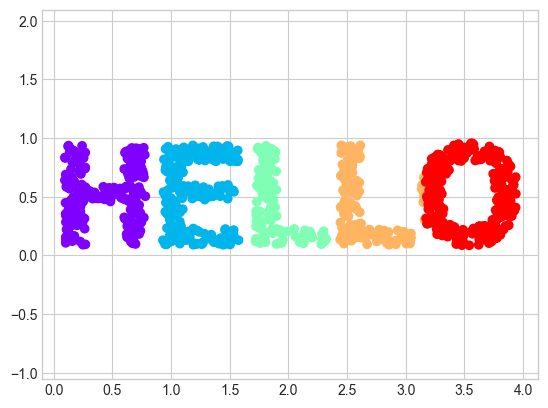

In [2]:
# 製造一個HELLO 資料集
def make_hello(N=1000, rseed=42):
    # 畫出HELLO 圖形 存成PNG檔
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center',
            weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)

    # 開啟PNG檔 然後畫一些隨機點
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j =(X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

# 呼叫函式
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

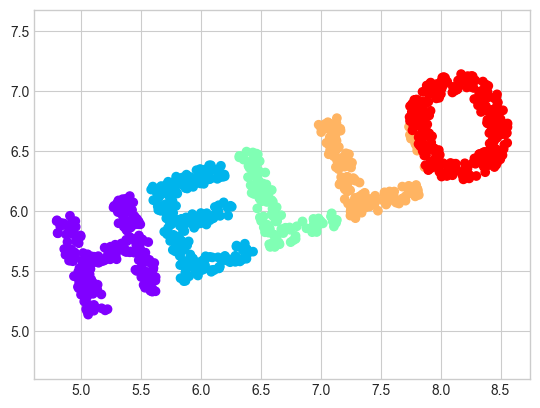

In [3]:
# 旋轉資料
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

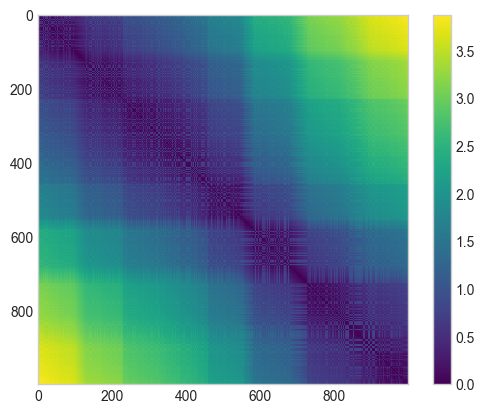

In [4]:
# 距離陣列
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)

plt.imshow(D, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

In [5]:
# 旋轉後的距離陣列內容相同
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

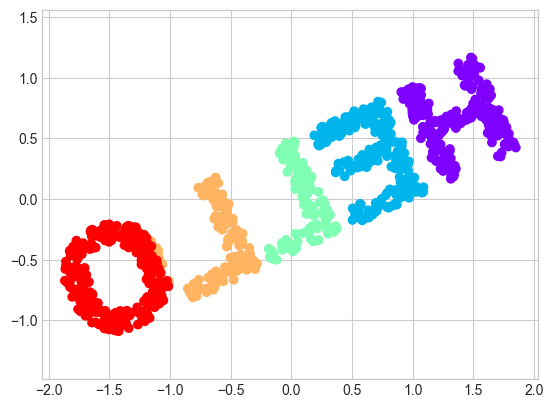

In [6]:
# MDS precomputed
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1701)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:,1], **colorize)
plt.axis('equal');

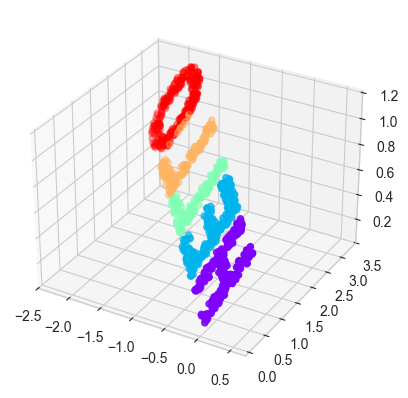

In [7]:
# 投影到三維
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])

X3 = random_projection(X, 3)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize);

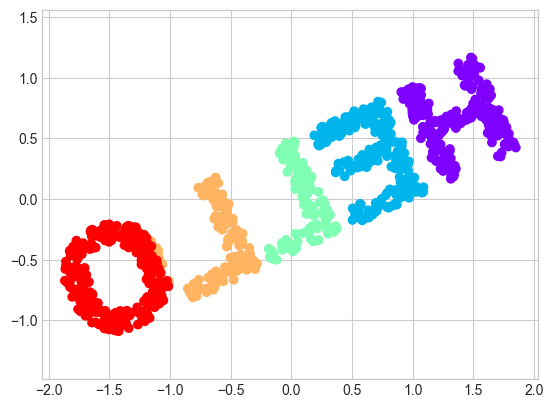

In [8]:
# 用 MDS 去算出最佳二維遷入關係
model = MDS(n_components=2, random_state=1701)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

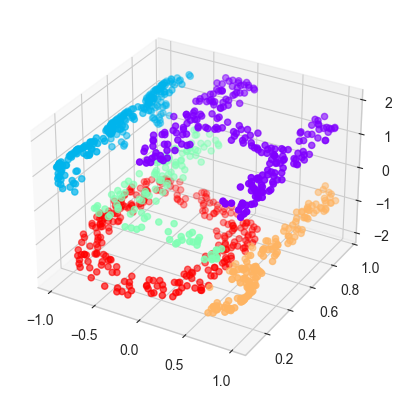

In [9]:
# 將資料在3維變形成S的形狀
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);

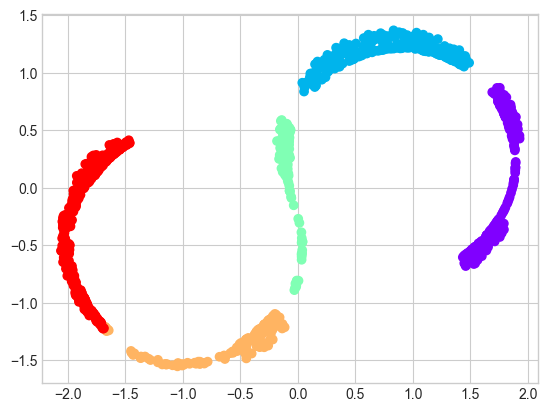

In [10]:
# MDS 找不出原始關係
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

(0.14, -0.15)

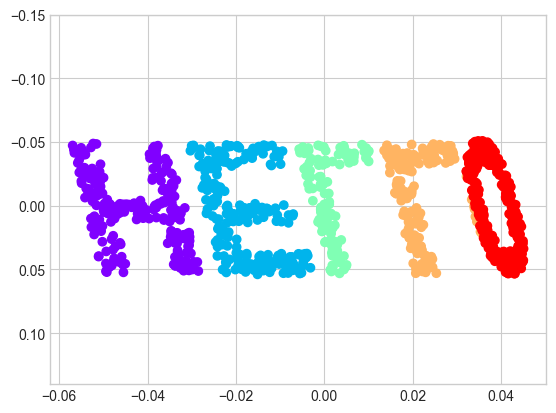

In [ ]:
# LLE 可以找出非線性資料的關係
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2,
                               method='modified', eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.14, -0.15)

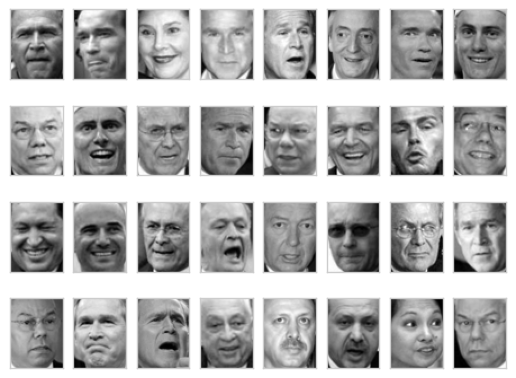

In [ ]:
# 匯入臉部圖片資料
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

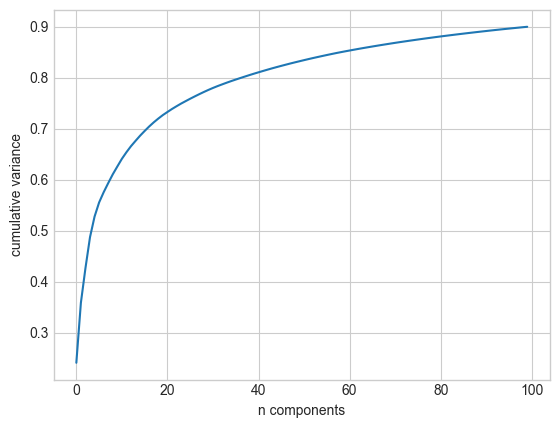

In [5]:
# 先用PCA看看
from sklearn.decomposition import PCA
model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [7]:
# 使用Isomap 將資料點投影到二維平面
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

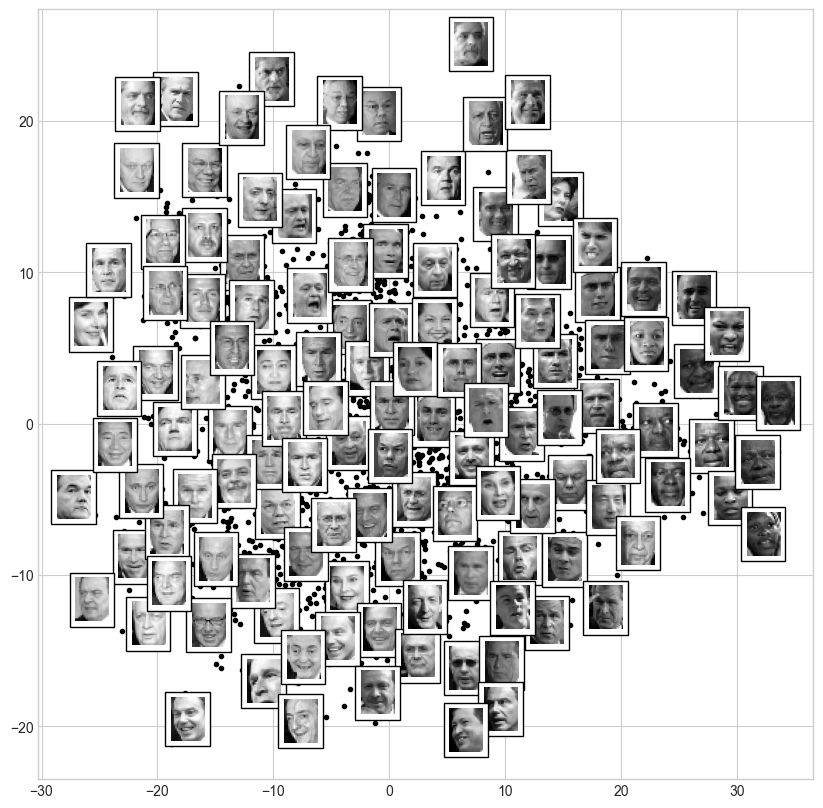

In [9]:
# 視覺化
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()

    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap), proj[i]
            )
            ax.add_artist(imagebox)

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

In [ ]:
# 匯入手寫數字資料集
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')
mnist.data.shape

(70000, 784)

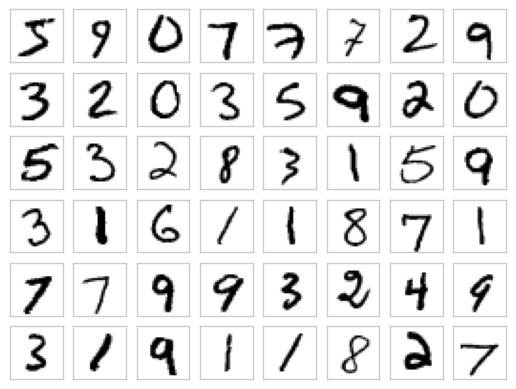

In [11]:
# 查看資料
mnist_data = np.asarray(mnist.data)
mnist_target = np.asarray(mnist.target, dtype=int)

fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist_data[1250 * i].reshape(28, 28), cmap='gray_r')

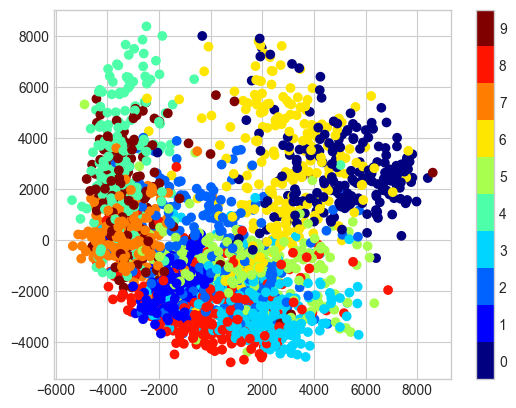

In [13]:
# 使用 1/30 的資料
data = mnist_data[::30]
target = mnist_target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)

plt.scatter(proj[:, 0], proj[:, 1], c=target,
            cmap=plt.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

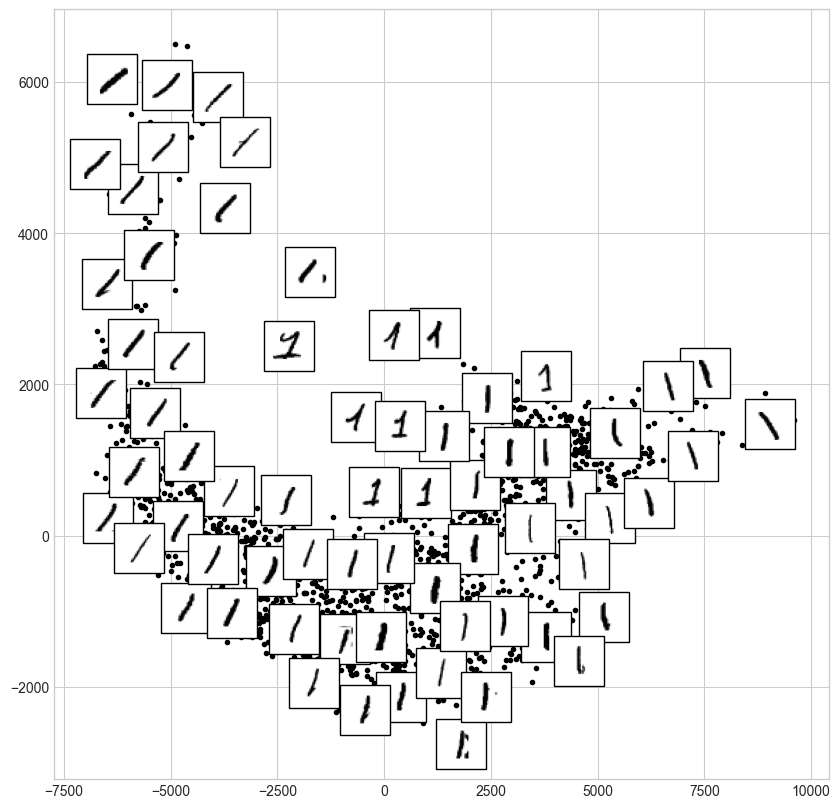

In [14]:
# 只看 1/4 的數字 1 的分布
data = mnist_data[mnist_target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')